# Imports

In [1]:
import numpy as np
import pandas as pd
import itertools
import pickle
from matplotlib import pyplot as plt
import datetime
from scipy import optimize
import sys
sys.path.append('../SEIR_full/')
sys.path.append('..')
import SEIR_full as mdl
import SEIR_full.model_class as mdl
import datetime as dt
from scipy.stats import poisson
from scipy.stats import binom
import copy
import os
import time

In [2]:
with (open('../Data/parameters/indices.pickle', 'rb')) as openfile:
    ind = pickle.load(openfile)

# setting calibration settings:

In [4]:
# cal_parameters = {}
cal_parameters = pd.read_pickle('../Data/calibration/calibration_dict.pickle')
# del old_cal_parameters['250']
# cal_parameters['20'] = old_cal_parameters
# cal_parameters['250'] = {
#     (1, 29):{
#         'beta_j': mdl.Beta2beta_j([0.02896186, 0.01990012, 0.01930463, 0.08039162]),
#         'theta': 2.10726431690474,
#         'beta_behave': 0.5355627091991568,
#     }
# }
cal_parameters
# with open('../Data/calibration/calibrattion_dict.pickle', 'wb') as handle:
#     pickle.dump(cal_parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)

{'base': {'beta_j': array([0.10167117, 0.10167117, 0.10167117, 0.05606748, 0.05606748,
         0.04709613, 0.04709613, 0.25676354, 0.25676354]),
  'theta': 2.0684200685446243,
  'beta_behave': 0.18876288297385702},
 '250': {(1,
   29): {'beta_j': array([0.02880126, 0.02880126, 0.02880126, 0.02039389, 0.02039389,
          0.01940452, 0.01940452, 0.08176075, 0.08176075]), 'theta': 2.08845636544809, 'beta_behave': 0.5297563921760634, 'eta': 0.30965204858355166, 'nu': 0.10209062063070717, 'xi': 0.1564269964927853, 'mu': 0.055360578653781634},
  (1,
   '-'): {'beta_j': array([0.05686523, 0.05686523, 0.05686523, 0.03910912, 0.03910912,
          0.03827064, 0.03827064, 0.16270906, 0.16270906]), 'theta': 2.124001880293494, 'beta_behave': 0.41323757547000334, 'eta': 0.30279553993325536, 'nu': 0.0976413466861567, 'xi': 0.15738064724569117, 'mu': 0.053283181126554946},
  (2,
   '-'): {'beta_j': array([0.04542143, 0.04542143, 0.04542143, 0.03493263, 0.03493263,
          0.03386302, 0.03386302,

# Intervention of slipped civil of const inter for 2000[d]

In [3]:
pct = range(30, 105, 10)
slipped_pct = np.arange(0, 11, 2)/10.0

# interventions to examine:
inter_list = ['20@' + str(x) + '_no_risk60_school_kid010' for x in pct]
inter_list = [x + '_slipped_risk('+str(slipped_pct[5])+')' for x in inter_list]

# parameters to examine:
parameters_list = [
#     '70%',
#     '75%',
#     '80%',
#     'ub',
    'base',
#     'lb',
]

results = {}

In [4]:
scen = 'Scenario2'
start_inter = pd.Timestamp('2020-05-03')
beginning = pd.Timestamp('2020-02-20')

cal_parameters = pd.read_pickle('../Data/calibration/calibrattion_dict.pickle')
cal_parameters = {key : cal_parameters[key] for key in parameters_list}

for key in cal_parameters.keys():
    model = mdl.Model_behave(
        ind=ind, 
        beta_j=cal_parameters[key]['beta_j'],
        theta=cal_parameters[key]['theta'],
        beta_behave=cal_parameters[key]['beta_behave'],
        eps=mdl.eps_sector[scen],
        f=mdl.f0_full[scen],
    )

    res_mdl = model.predict(
        C=mdl.C_calibration,
        days_in_season=(start_inter-beginning).days,
        stay_home_idx=mdl.stay_home_idx,
        not_routine=mdl.not_routine,
    )
    for pct_i in pct:
        for slipped_pct_i in slipped_pct:
            inter_name = '20@' + str(pct_i) + '_no_risk60_school_kid010' + '_slipped_risk('+str(slipped_pct_i)+')'
            # First intervention
            with open('../Data/interventions/C_inter_' + inter_name + '.pickle', 'rb') as pickle_in:
                C_inter = pickle.load(pickle_in)

            with open('../Data/interventions/stay_home_idx_inter_' + inter_name + '.pickle', 'rb') as pickle_in:
                stay_home_idx_inter = pickle.load(pickle_in)

            with open('../Data/interventions/routine_t_inter_' + inter_name + '.pickle', 'rb') as pickle_in:
                routine_t_inter = pickle.load(pickle_in)

            with open('../Data/interventions/transfer_pop_inter_' + inter_name + '.pickle', 'rb') as pickle_in:
                transfer_pop_inter = pickle.load(pickle_in)

            model_inter = copy.deepcopy(model)
            res_mdl = model_inter.intervention(
                C =C_inter,
                days_in_season=2000,
                stay_home_idx=stay_home_idx_inter,
                not_routine=routine_t_inter,
                prop_dict=transfer_pop_inter,
            )
    #         # fix 60 offset
    #         for i, vent in enumerate(res_mdl['Vents']):
    #             res_mdl['Vents'][i] = vent + ((60.0/mdl.pop_israel)*vent)/vent.sum()

            print(key, ' parameters, intervention: ', inter_name, ' we got:')
    #         ['Vents'].sum()*mdl.pop_israel*model.mu*0.5
            results[(pct_i, slipped_pct_i, key)] = res_mdl
    #         print('number ot total casulties is: ', results[(inter_name, key)])
    #         print('Recovered cases max: ', (((res_mdl['R'])[:(start_inter-beginning).days+90].sum(axis=1))*mdl.pop_israel).max())
    #         mdl.plot_I_by_age(model.ind, res_mdl)
    #         mdl.plot_R_by_age(ind, res_mdl)
#             mdl.plot_respiration_cases(res_mdl, (start_inter-beginning).days)
    #         mdl.plot_hospitalization_cases(res_mdl)
    #         results[(inter_name, key)] = res_mdl

base  parameters, intervention:  20@30_no_risk60_school_kid010_slipped_risk(0.0)  we got:
base  parameters, intervention:  20@30_no_risk60_school_kid010_slipped_risk(0.2)  we got:
base  parameters, intervention:  20@30_no_risk60_school_kid010_slipped_risk(0.4)  we got:
base  parameters, intervention:  20@30_no_risk60_school_kid010_slipped_risk(0.6)  we got:
base  parameters, intervention:  20@30_no_risk60_school_kid010_slipped_risk(0.8)  we got:
base  parameters, intervention:  20@30_no_risk60_school_kid010_slipped_risk(1.0)  we got:
base  parameters, intervention:  20@40_no_risk60_school_kid010_slipped_risk(0.0)  we got:
base  parameters, intervention:  20@40_no_risk60_school_kid010_slipped_risk(0.2)  we got:
base  parameters, intervention:  20@40_no_risk60_school_kid010_slipped_risk(0.4)  we got:
base  parameters, intervention:  20@40_no_risk60_school_kid010_slipped_risk(0.6)  we got:
base  parameters, intervention:  20@40_no_risk60_school_kid010_slipped_risk(0.8)  we got:
base  para

KeyboardInterrupt: 

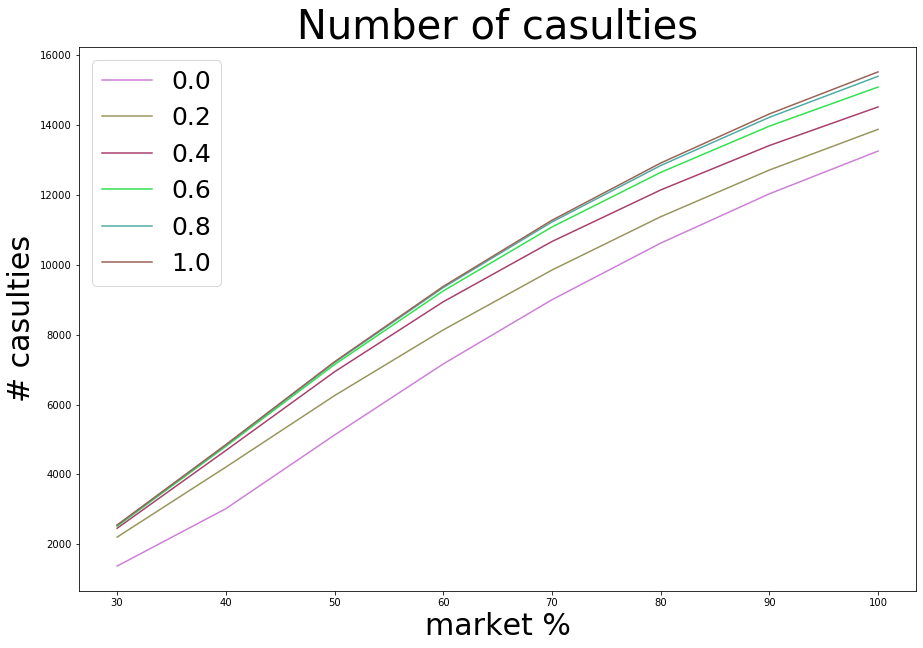

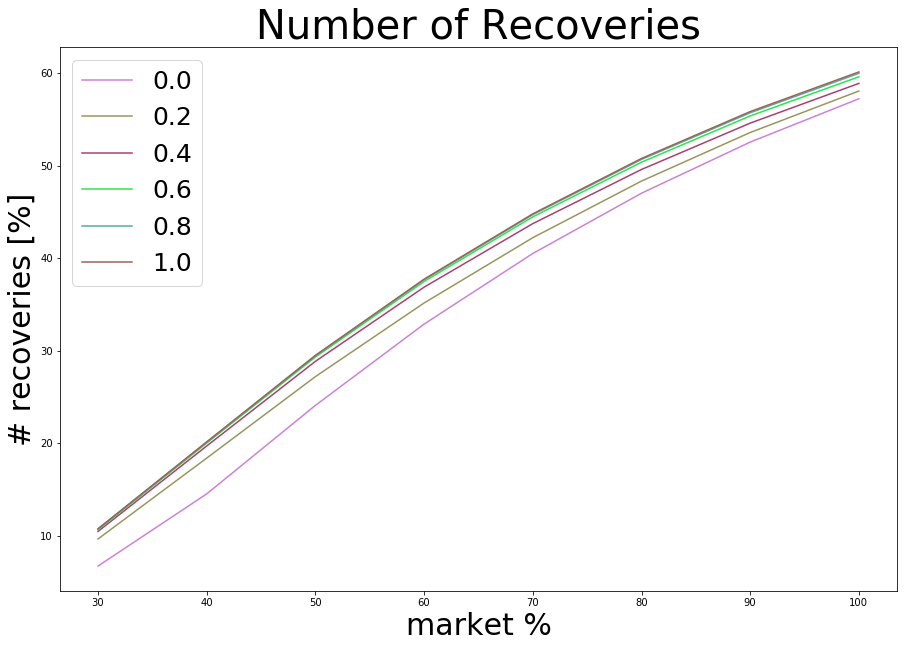

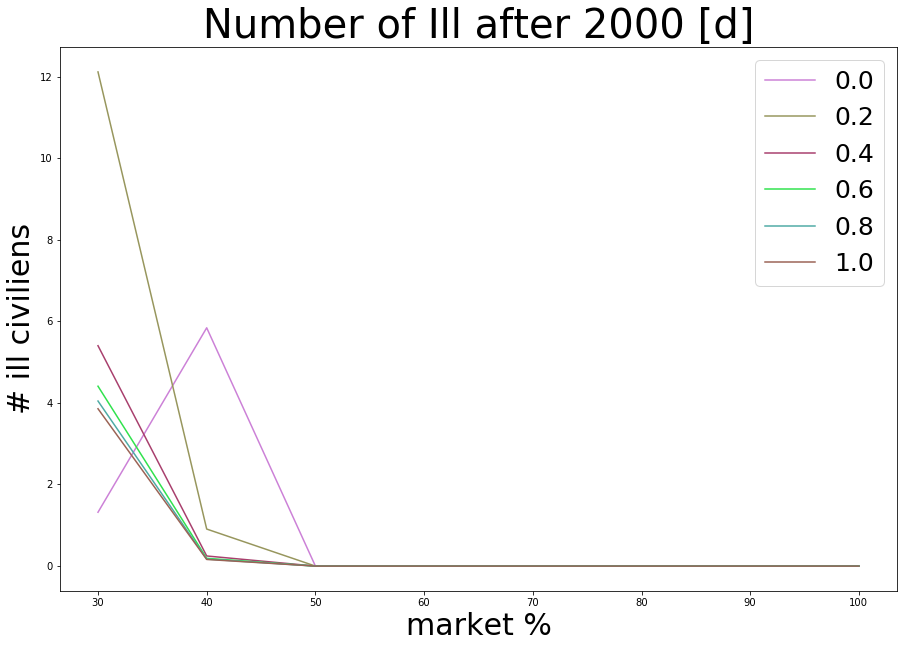

In [11]:
def make_casulties(res_model, time_ahead):
    return (res_model['Vents'].sum(axis=1))[:time_ahead].sum()*mdl.pop_israel*model.mu*0.5

def make_recoveries(res_model, time_ahead):
    return (res_model['R'].sum(axis=1))[time_ahead]*100

def make_ill_end(res_model, time_ahead):
    return ((res_model['Ie']+res_model['Is']+res_model['Ia']).sum(axis=1))[time_ahead]*mdl.pop_israel

key = 'base'
plt.figure(figsize=(15,10))
c = np.random.rand(len(slipped_pct),3)
for i, slipped_pct_i in enumerate(slipped_pct):
    plt.plot(pct, [make_casulties(results[(pct_i, slipped_pct_i, key)], 2000) for pct_i in pct], c=c[i,:])
#     plt.plot(pct, [make_casulties(results[(pct_i, slipped_pct_i, key)], 300) for pct_i in pct], c=c[i,:], label='_nolegend_')
plt.title('Number of casulties', fontsize=40)
plt.xlabel('market %', fontsize=30)
plt.ylabel('# casulties', fontsize=30)
plt.legend(slipped_pct, fontsize=25)

plt.figure(figsize=(15,10))
for i, slipped_pct_i in enumerate(slipped_pct):

    plt.plot(pct, [make_recoveries(results[(pct_i, slipped_pct_i, key)], 2000) for pct_i in pct], c=c[i,:])
plt.title('Number of Recoveries', fontsize=40)
plt.xlabel('market %', fontsize=30)
plt.ylabel('# recoveries [%]', fontsize=30)
plt.legend(slipped_pct, fontsize=25)

plt.figure(figsize=(15,10))
for i, slipped_pct_i in enumerate(slipped_pct):
    plt.plot(pct, [make_ill_end(results[(pct_i, slipped_pct_i, key)], 2000) for pct_i in pct], c=c[i,:])
plt.title('Number of Ill after 2000 [d]', fontsize=40)
plt.xlabel('market %', fontsize=30)
plt.ylabel('# ill civiliens', fontsize=30)
plt.legend(slipped_pct, fontsize=25)

# Comparing UB to base in case of no degredation

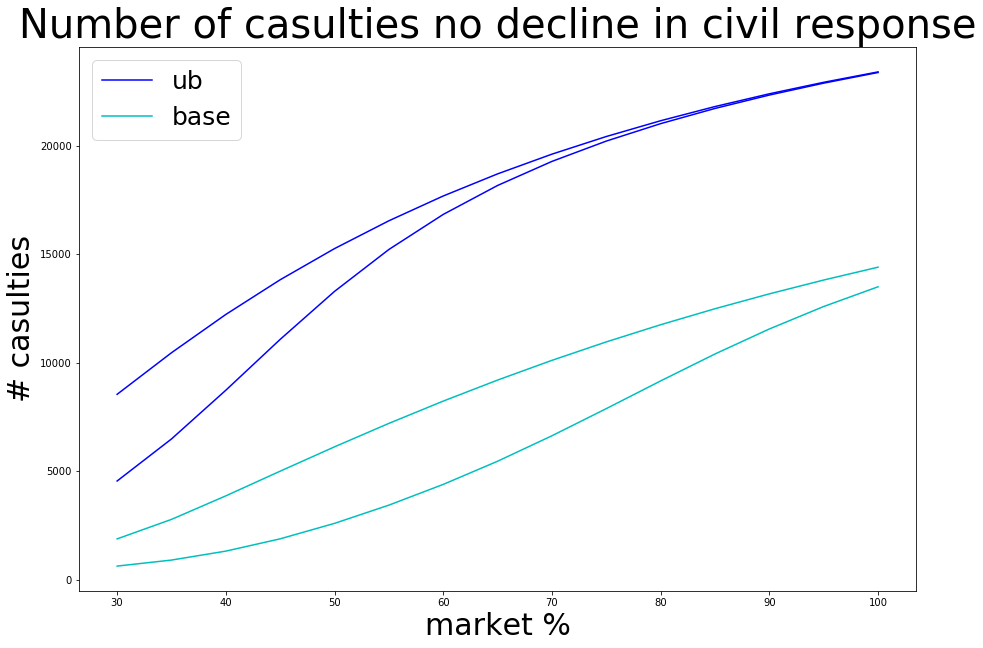

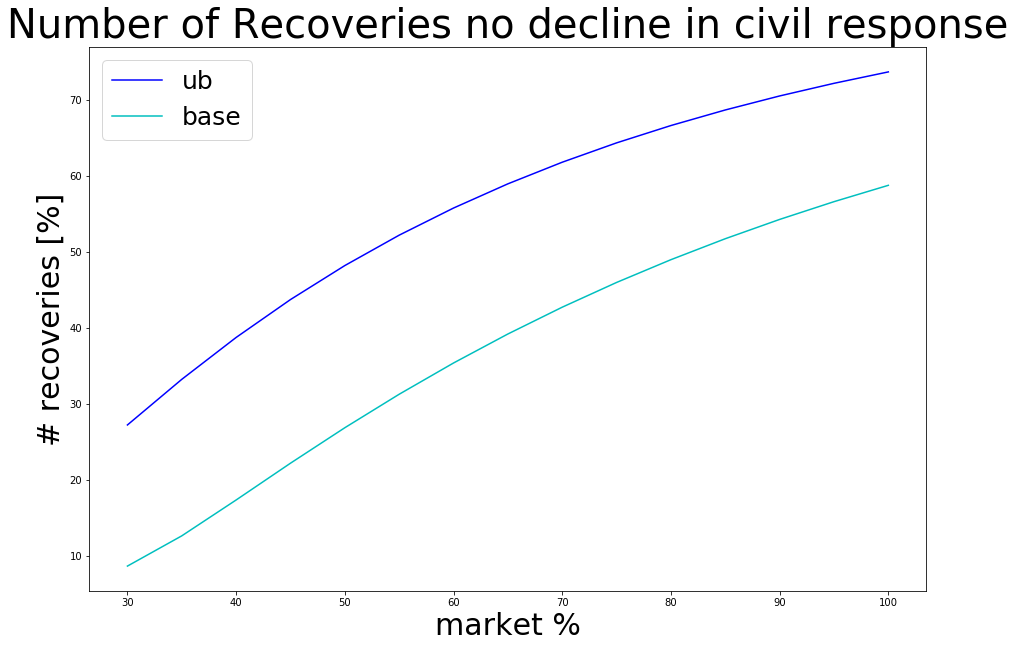

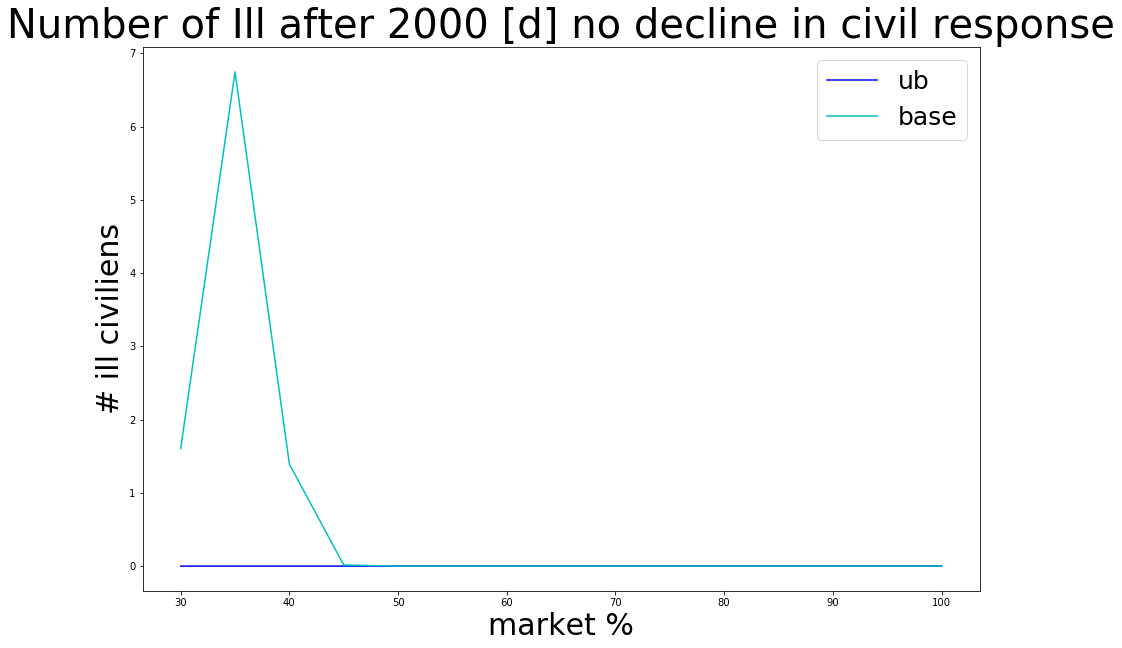

In [51]:
def make_casulties(res_model, time_ahead):
    return (res_model['Vents'].sum(axis=1))[:time_ahead].sum()*mdl.pop_israel*model.mu*0.5

def make_recoveries(res_model, time_ahead):
    return (res_model['R'].sum(axis=1))[time_ahead]*100

def make_ill_end(res_model, time_ahead):
    return ((res_model['Ie']+res_model['Is']+res_model['Ia']).sum(axis=1))[time_ahead]*mdl.pop_israel

plt.figure(figsize=(15,10))
c_casul=['b', 'c']
for i, key in enumerate(cal_parameters.keys()):
    plt.plot(pct, [make_casulties(results[(inter_name, key)], 2000) for inter_name in inter_list], c=c[i])
    plt.plot(pct, [make_casulties(results[(inter_name, key)], 300) for inter_name in inter_list], c=c[i], label='_nolegend_')
plt.title('Number of casulties no decline in civil response', fontsize=40)
plt.xlabel('market %', fontsize=30)
plt.ylabel('# casulties', fontsize=30)
plt.legend(list(cal_parameters.keys()), fontsize=25)

plt.figure(figsize=(15,10))
c_casul=['b', 'c']
for i, key in enumerate(cal_parameters.keys()):
    plt.plot(pct, [make_recoveries(results[(inter_name, key)], 2000) for inter_name in inter_list], c=c[i])
plt.title('Number of Recoveries no decline in civil response', fontsize=40)
plt.xlabel('market %', fontsize=30)
plt.ylabel('# recoveries [%]', fontsize=30)
plt.legend(list(cal_parameters.keys()), fontsize=25)

plt.figure(figsize=(15,10))
c_casul=['b', 'c']
for i, key in enumerate(cal_parameters.keys()):
    plt.plot(pct, [make_ill_end(results[(inter_name, key)], 2000) for inter_name in inter_list], c=c[i])
plt.title('Number of Ill after 2000 [d] no decline in civil response', fontsize=40)
plt.xlabel('market %', fontsize=30)
plt.ylabel('# ill civiliens', fontsize=30)
plt.legend(list(cal_parameters.keys()), fontsize=25)

# Comparing slow release to sudden period of 5 [m]

In [3]:
last = 100
final = mdl.inter2name(ind, last, no_risk=False)

pct_ramp = range(30, last+5, 5)
single_pct_list = [50, 75, 100] # the single to compare ramp to.

# interventions to examine:
inter_rmp = [mdl.inter2name(ind, x, no_risk=True) for x in pct_ramp]

time2last_inter = 150 # dayes

# deg_param = {
#     'inter_max':mdl.inter2name(ind, last, no_risk=False),
#     'deg_rate': last/float(time2last_inter),
#     'max_deg_rate': last,
# }
deg_param = None

# parameters to examine:
parameters_list = [
#     '70%',
#     '75%',
#     '80%',
#     'ub',
    'base',
#     'lb',
]

results = {}

In [4]:
inter_lists = [
    [mdl.inter2name(ind, single_pct, no_risk=True),inter_rmp[-1]] 
    for single_pct in single_pct_list
]

inter_lists.append(inter_rmp)
for i in range(len(inter_lists)):
    inter_lists[i][-1] = final
    
inter_times_lists = [
    [time2last_inter]
]*len(single_pct_list)

delta_t = int(time2last_inter/(float(len(inter_rmp)-1)))
inter_times_lists.append([delta_t] * (len(inter_rmp)-1))

In [5]:
scen = 'Scenario2'
start_inter = pd.Timestamp('2020-05-03')
beginning = pd.Timestamp('2020-02-20')

cal_parameters = pd.read_pickle('../Data/calibration/calibrattion_dict.pickle')
cal_parameters = {key : cal_parameters[ind.cell_name][key] for key in parameters_list}

for key in cal_parameters.keys():
    model = mdl.Model_behave(
        ind=ind, 
        beta_j=cal_parameters[key]['beta_j'],
        theta=cal_parameters[key]['theta'],
        beta_behave=cal_parameters[key]['beta_behave'],
        eps=mdl.eps_sector[scen],
        f=mdl.f0_full[scen],
    )

    model.predict(
        C=mdl.C_calibration,
        days_in_season=(start_inter-beginning).days,
        stay_home_idx=mdl.stay_home_idx,
        not_routine=mdl.not_routine,
    )
    
    _, model = mdl.multi_inter_by_name(
            ind, 
            model, 
            mdl.pop_israel, 
            [mdl.inter2name(ind, 30, no_risk=False,no_kid=False,)],
            sim_length=7, 
            fix_vents=False,
    )
    
    for i in range(len(inter_times_lists)):
        res_mdl, _ = mdl.multi_inter_by_name(
            ind, 
            model, 
            mdl.pop_israel, 
            inter_lists[i], 
            inter_times_lists[i], 
            sim_length=1200, 
            fix_vents=False,
            deg_param = deg_param,
            no_pop=True,
        )
        results[(key, i)] = res_mdl
#     # fix 60 offset
#     for i, vent in enumerate(res_mdl['Vents']):
#         res_mdl['Vents'][i] = vent + ((60.0/mdl.pop_israel)*vent)/vent.sum()

    print(key, ' parameters, we got:')

base  parameters, we got:


Recovered cases max:  45.57057387433734
total casulties:  5452.639042756026
Recovered cases max:  45.206948180506664
total casulties:  5392.104492110239
Recovered cases max:  47.953629377057595
total casulties:  5754.626260931058
Recovered cases max:  46.72170752952221
total casulties:  5604.256401305171


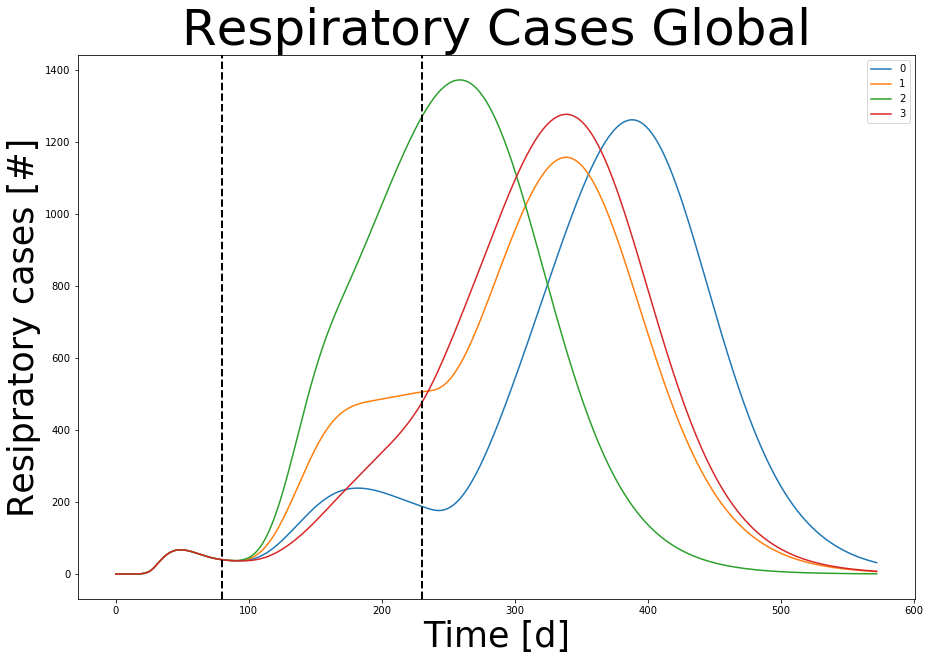

In [6]:
for key in cal_parameters.keys():
    for i in range(len(inter_times_lists)):
        print('Recovered cases max: ', mdl.make_recoveries(results[(key, i)], -1))
        print('total casulties: ', mdl.make_casulties(results[(key, i)], -1, mdl.pop_israel, model.mu))

fig, ax = plt.subplots(figsize=(15, 10))
for key in cal_parameters.keys():
    for i in range(len(inter_times_lists)):
        ax.plot(((results[(key, i)]['Vents']).sum(axis=1))*mdl.pop_israel, label=str(i))
ax.set_ylabel('Resipratory cases [#]', fontsize=35)
ax.set_title('Respiratory Cases Global', fontsize=50)
ax.set_xlabel('Time [d]', fontsize=35)
ax.axvline(x=(start_inter-beginning).days+7, c='k', linewidth=2, linestyle='--')
ax.axvline(x=(start_inter-beginning).days+time2last_inter+7, c='k', linewidth=2, linestyle='--')
ax.legend()
plt.show()

In [18]:
rmp = ((res_rmp['Vents']).sum(axis=1))*mdl.pop_israel
single = ((res_single['Vents']).sum(axis=1))*mdl.pop_israel

f = 1/365
phi = (pd.Timestamp('2020-05-24')-beginning).days
season = np.sin(np.arange(0,len(rmp))*2*np.pi*f-phi)
rmp *= 1+0.2*season
single *= 1+0.2*season

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(rmp)
ax.plot(single)
ax.set_ylabel('Resipratory cases [#]', fontsize=35)
ax.set_title('Respiratory Cases Global', fontsize=50)
ax.set_xlabel('Time [d]', fontsize=35)
ax.axvline(x=(start_inter-beginning).days, c='k', linewidth=2, linestyle='--')
ax.axvline(x=(start_inter-beginning).days+time2last_inter, c='k', linewidth=2, linestyle='--')
ax.legend(['ramping up from 30%', '75%'])

plt.show()

NameError: name 'res_rmp' is not defined

# Comparing kid with no kid

In [15]:
last = 100
final = mdl.inter2name(ind, last, no_risk=False)

pct_ramp = range(30, last+5, 5)
single_pct_list = [100] # the single to compare ramp to.
kid_comb = [
    [
        {
            'no_kid': False,
            'kid_019': True,
        },
    ],
#     [
#         {
#             'no_kid': False,
#             'kid_019': False,
#             'kid_09': False,
#             'kid_04': True,
#         },
#         {
#             'no_kid': False,
#             'kid_019': False,
#             'kid_09': True,
#         },
#         {
#             'no_kid': False,
#             'kid_019': True,
#         },
#     ],
]

time2last_inter = 150 # dayes

# deg_param = {
#     'inter_max':mdl.inter2name(ind, last, no_risk=False),
#     'deg_rate': last/float(time2last_inter),
# #     'deg_rate': 20,
#     'max_deg_rate': last,
# }
deg_param = None

# parameters to examine:
parameters_list = [
#     '70%',
#     '75%',
#     '80%',
#     'ub',
    'base',
#     'lb',
]

results = {}

In [16]:
inter_lists = []
for pct, kid_list in itertools.product(single_pct_list, kid_comb):
    inter_lists.append([
        mdl.inter2name(ind, pct, no_risk=False, **kid_dict) 
        for kid_dict in kid_list
    ] + [final])

inter_times_lists = []
for pct, kid_list in itertools.product(single_pct_list, kid_comb):
    base_time = int(time2last_inter/(float(len(kid_list))))
    time_list = []
    for i, kid_dict in enumerate(kid_list):
        if i==len(kid_list)-1:
            cur_time = time2last_inter - base_time*(len(kid_list)-1)
        else:
            cur_time = base_time
        time_list.append(cur_time)
    inter_times_lists.append(time_list)

In [17]:
scen = 'Scenario2'
start_inter = pd.Timestamp('2020-05-03')
beginning = pd.Timestamp('2020-02-20')

cal_parameters = pd.read_pickle('../Data/calibration/calibrattion_dict.pickle')
cal_parameters = {key : cal_parameters[ind.cell_name][key] for key in parameters_list}

for key in cal_parameters.keys():
#     model = mdl.Model_behave(
#         ind=ind, 
#         beta_j=cal_parameters[key]['beta_j'],
#         theta=cal_parameters[key]['theta'],
#         beta_behave=cal_parameters[key]['beta_behave'],
#         eps=mdl.eps_sector[scen],
#         f=mdl.f0_full[scen],
#     )
    model = mdl.Model_behave(
        ind=ind,
        beta_j=np.array([0.10167117, 0.10167117, 0.10167117, 0.05606748, 0.05606748,
           0.04709613, 0.04709613, 0.25676354, 0.25676354])*0.35,
        theta=2.0684200685446243,
        beta_behave=0.4,
        eps=mdl.eps_sector['Scenario1'],
        f=mdl.f0_full['Scenario1'],
        seasonality=True
    )

    model.predict(
        C=mdl.C_calibration,
        days_in_season=(start_inter-beginning).days,
        stay_home_idx=mdl.stay_home_idx,
        not_routine=mdl.not_routine,
    )
    
    _, model = mdl.multi_inter_by_name(
            ind, 
            model, 
            mdl.pop_israel, 
            [mdl.inter2name(ind, 30, no_risk=False,no_kid=False,)],
            sim_length=7, 
            fix_vents=False,
    )
    
    for i in range(len(inter_times_lists)):
        res_mdl, _ = mdl.multi_inter_by_name(
            ind, 
            model, 
            mdl.pop_israel, 
            inter_lists[i], 
            inter_times_lists[i], 
            sim_length=1200, 
            fix_vents=False,
            deg_param = deg_param,
            no_pop=True,
        )
        results[(key, i, deg_param is None)] = res_mdl
#     # fix 60 offset
#     for i, vent in enumerate(res_mdl['Vents']):
#         res_mdl['Vents'][i] = vent + ((60.0/mdl.pop_israel)*vent)/vent.sum()

    print(key, ' parameters, we got:')

base  parameters, we got:


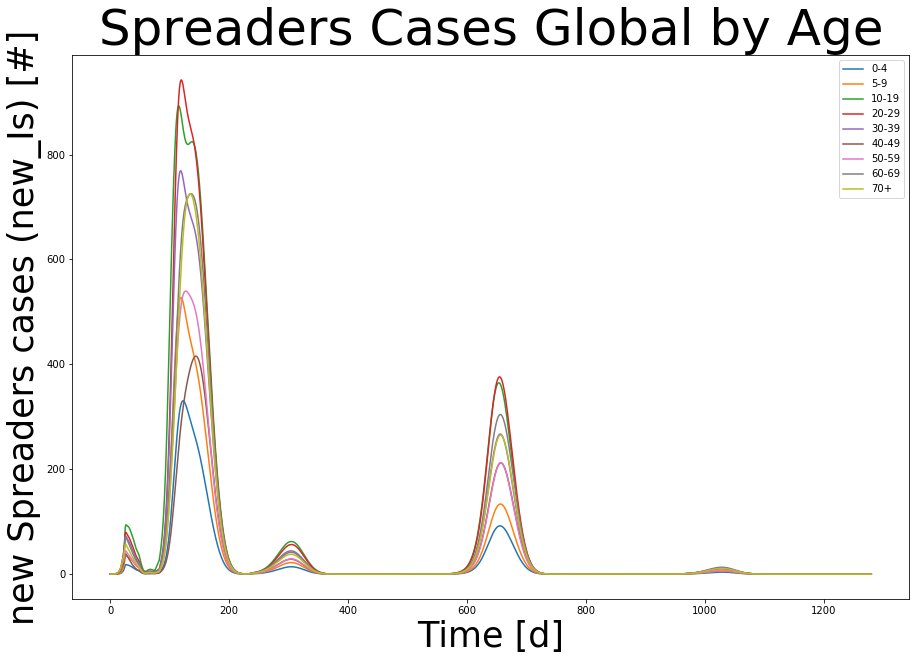

(<Figure size 1080x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x99efba8>)

In [18]:
mdl.plot_I_by_age(ind,results[('base', 0, True)], new_only=True)

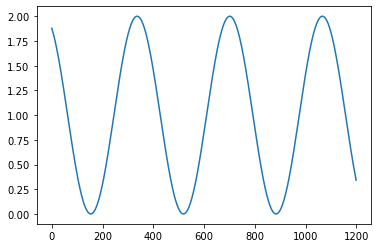

In [14]:
t = np.arange(1200)
plt.plot(t, 1 + np.cos((2 * np.pi * (t + model.phi)) / 365.0))

In [9]:
for key in cal_parameters.keys():
    for i in range(len(inter_lists)):
        print(inter_lists[i], False)
        print(inter_times_lists[i])
        print('Recovered cases max: ', mdl.make_recoveries(results[(key, i, False)], -1))
        print('total casulties: ', mdl.make_casulties(results[(key, i, False)], -1, mdl.pop_israel, model.mu))

fig, ax = plt.subplots(figsize=(15, 10))
for key in cal_parameters.keys():
    for i in range(len(inter_times_lists)):
        ax.plot(((results[(key, i, False)]['Vents']).sum(axis=1))*mdl.pop_israel, label=str(i))
ax.set_ylabel('Resipratory cases [#]', fontsize=35)
ax.set_title('Respiratory Cases Global', fontsize=50)
ax.set_xlabel('Time [d]', fontsize=35)
ax.axvline(x=(start_inter-beginning).days+7, c='k', linewidth=2, linestyle='--')
ax.axvline(x=(start_inter-beginning).days+time2last_inter+7, c='k', linewidth=2, linestyle='--')
plt.setp(ax.get_xticklabels(), fontsize=20)    
plt.setp(ax.get_yticklabels(), fontsize=20) 
ax.legend(fontsize = 20)
plt.show()

['250@100_no_risk60_kid019', '250@100_kid019'] False
[150, 1050]


KeyError: ('base', 0, False)

['250@100_no_risk60_kid019', '250@100_kid019'] True
[150, 1050]
Recovered cases max:  24.965290323880495
total casulties:  3257.380898718215


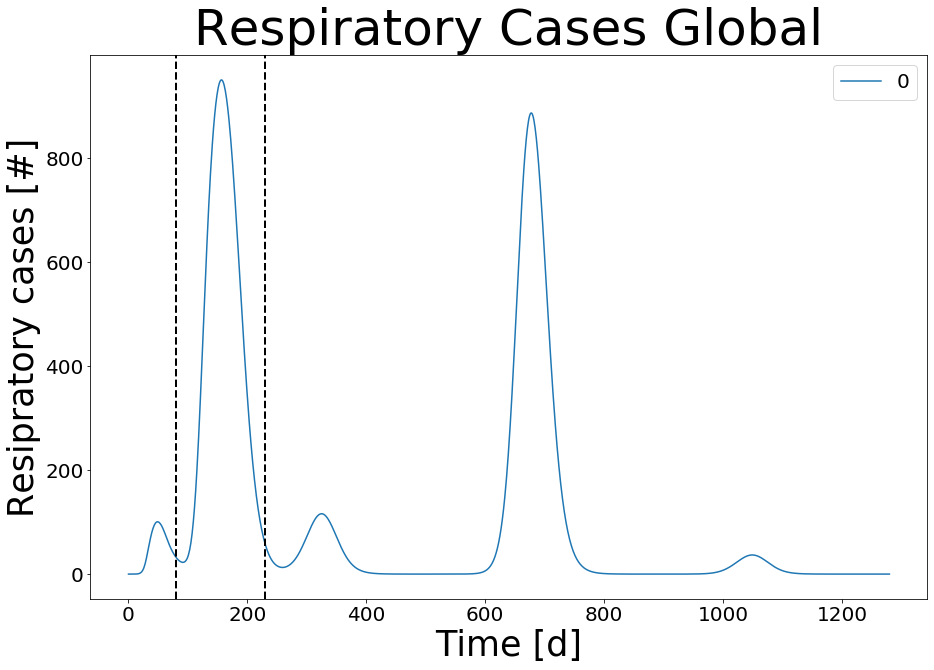

In [10]:
for key in cal_parameters.keys():
    for i in range(len(inter_lists)):
        print(inter_lists[i], True)
        print(inter_times_lists[i])
        print('Recovered cases max: ', mdl.make_recoveries(results[(key, i, True)], -1))
        print('total casulties: ', mdl.make_casulties(results[(key, i, True)], -1, mdl.pop_israel, model.mu))

fig, ax = plt.subplots(figsize=(15, 10))
for key in cal_parameters.keys():
    for i in range(len(inter_times_lists)):
        ax.plot(((results[(key, i, True)]['Vents']).sum(axis=1))*mdl.pop_israel, label=str(i))
ax.set_ylabel('Resipratory cases [#]', fontsize=35)
ax.set_title('Respiratory Cases Global', fontsize=50)
ax.set_xlabel('Time [d]', fontsize=35)
ax.axvline(x=(start_inter-beginning).days+7, c='k', linewidth=2, linestyle='--')
ax.axvline(x=(start_inter-beginning).days+time2last_inter+7, c='k', linewidth=2, linestyle='--')
plt.setp(ax.get_xticklabels(), fontsize=20)    
plt.setp(ax.get_yticklabels(), fontsize=20) 
ax.legend(fontsize = 20)
plt.show()

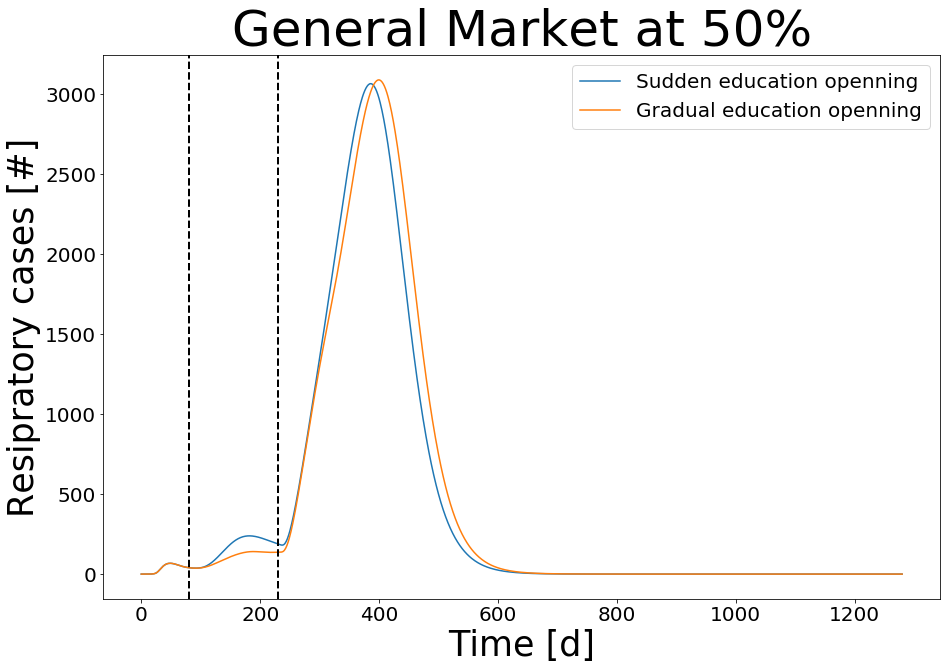

In [44]:
fig, ax = plt.subplots(figsize=(15, 10))
for key in cal_parameters.keys():
        ax.plot(((results[(key, 0, True)]['Vents']).sum(axis=1))*mdl.pop_israel, label='Sudden education openning')
        ax.plot(((results[(key, 1, True)]['Vents']).sum(axis=1))*mdl.pop_israel, label='Gradual education openning')
ax.set_ylabel('Resipratory cases [#]', fontsize=35)
ax.set_title('General Market at 50%', fontsize=50)
ax.set_xlabel('Time [d]', fontsize=35)
ax.axvline(x=(start_inter-beginning).days+7, c='k', linewidth=2, linestyle='--')
ax.axvline(x=(start_inter-beginning).days+time2last_inter+7, c='k', linewidth=2, linestyle='--')
plt.setp(ax.get_xticklabels(), fontsize=20)    
plt.setp(ax.get_yticklabels(), fontsize=20) 
ax.legend(fontsize = 20)
plt.show()

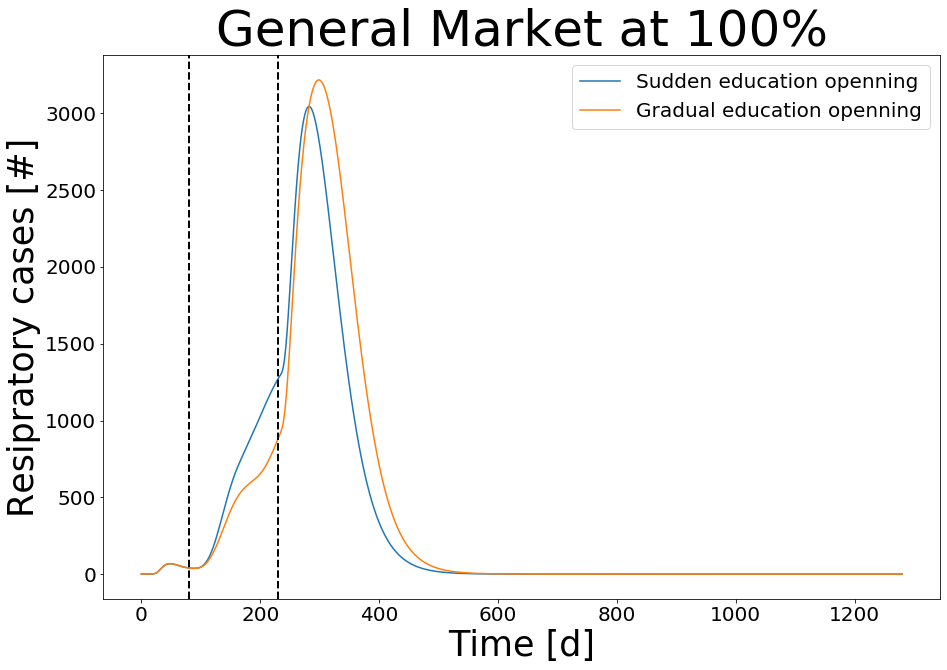

In [45]:
fig, ax = plt.subplots(figsize=(15, 10))
for key in cal_parameters.keys():
        ax.plot(((results[(key, 4, True)]['Vents']).sum(axis=1))*mdl.pop_israel, label='Sudden education openning')
        ax.plot(((results[(key, 5, True)]['Vents']).sum(axis=1))*mdl.pop_israel, label='Gradual education openning')
ax.set_ylabel('Resipratory cases [#]', fontsize=35)
ax.set_title('General Market at 100%', fontsize=50)
ax.set_xlabel('Time [d]', fontsize=35)
ax.axvline(x=(start_inter-beginning).days+7, c='k', linewidth=2, linestyle='--')
ax.axvline(x=(start_inter-beginning).days+time2last_inter+7, c='k', linewidth=2, linestyle='--')
plt.setp(ax.get_xticklabels(), fontsize=20)    
plt.setp(ax.get_yticklabels(), fontsize=20) 
ax.legend(fontsize = 20)
plt.show()

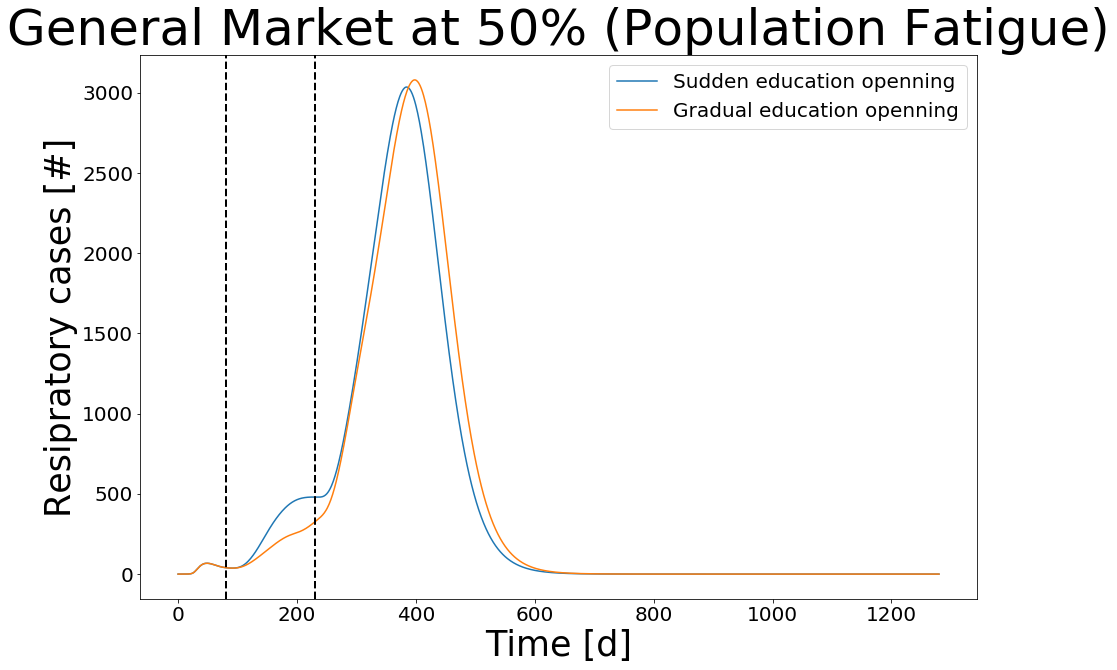

In [46]:
fig, ax = plt.subplots(figsize=(15, 10))
for key in cal_parameters.keys():
        ax.plot(((results[(key, 0, False)]['Vents']).sum(axis=1))*mdl.pop_israel, label='Sudden education openning')
        ax.plot(((results[(key, 1, False)]['Vents']).sum(axis=1))*mdl.pop_israel, label='Gradual education openning')
ax.set_ylabel('Resipratory cases [#]', fontsize=35)
ax.set_title('General Market at 50% (Population Fatigue)', fontsize=50)
ax.set_xlabel('Time [d]', fontsize=35)
ax.axvline(x=(start_inter-beginning).days+7, c='k', linewidth=2, linestyle='--')
ax.axvline(x=(start_inter-beginning).days+time2last_inter+7, c='k', linewidth=2, linestyle='--')
plt.setp(ax.get_xticklabels(), fontsize=20)    
plt.setp(ax.get_yticklabels(), fontsize=20) 
ax.legend(fontsize = 20)
plt.show()

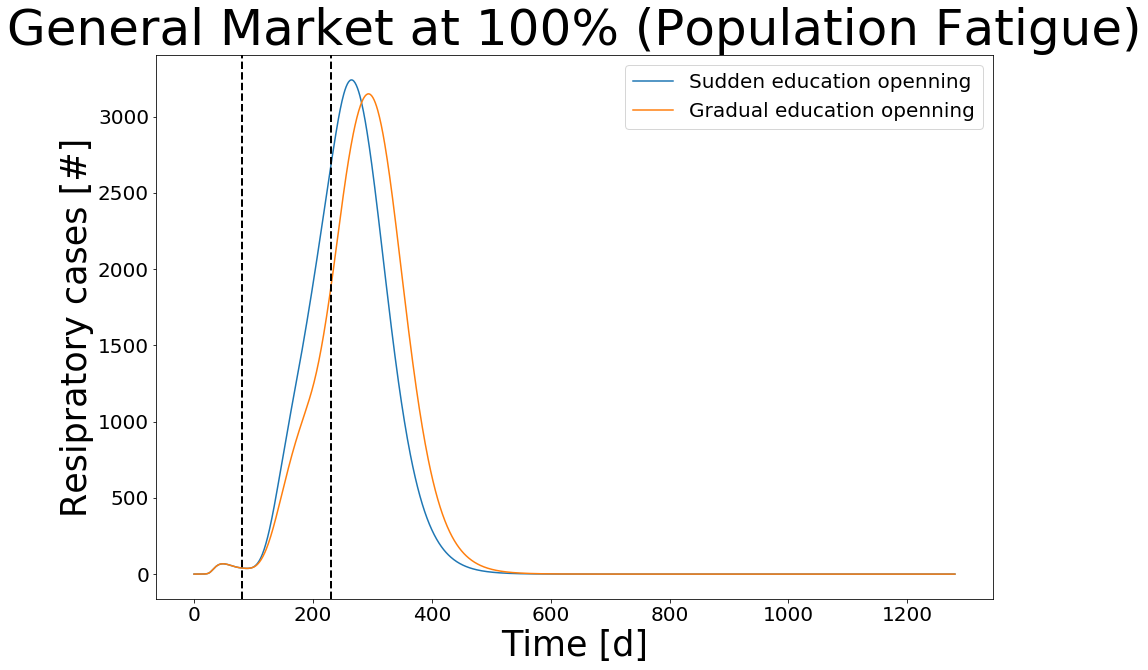

In [47]:
fig, ax = plt.subplots(figsize=(15, 10))
for key in cal_parameters.keys():
        ax.plot(((results[(key, 4, False)]['Vents']).sum(axis=1))*mdl.pop_israel, label='Sudden education openning')
        ax.plot(((results[(key, 5, False)]['Vents']).sum(axis=1))*mdl.pop_israel, label='Gradual education openning')
ax.set_ylabel('Resipratory cases [#]', fontsize=35)
ax.set_title('General Market at 100% (Population Fatigue)', fontsize=50)
ax.set_xlabel('Time [d]', fontsize=35)
ax.axvline(x=(start_inter-beginning).days+7, c='k', linewidth=2, linestyle='--')
ax.axvline(x=(start_inter-beginning).days+time2last_inter+7, c='k', linewidth=2, linestyle='--')
plt.setp(ax.get_xticklabels(), fontsize=20)    
plt.setp(ax.get_yticklabels(), fontsize=20) 
ax.legend(fontsize = 20)
plt.show()

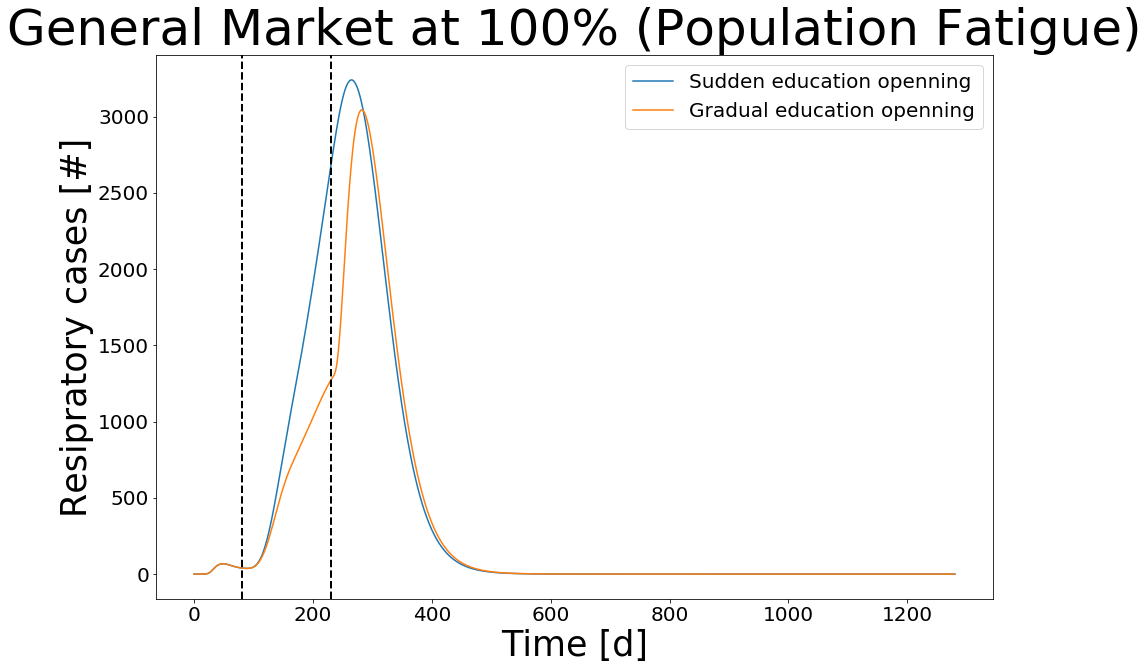

In [43]:
fig, ax = plt.subplots(figsize=(15, 10))
for key in cal_parameters.keys():
        ax.plot(((results[(key, 4, False)]['Vents']).sum(axis=1))*mdl.pop_israel, label='Sudden education openning')
        ax.plot(((results[(key, 4, True)]['Vents']).sum(axis=1))*mdl.pop_israel, label='Gradual education openning')
ax.set_ylabel('Resipratory cases [#]', fontsize=35)
ax.set_title('General Market at 100% (Population Fatigue)', fontsize=50)
ax.set_xlabel('Time [d]', fontsize=35)
ax.axvline(x=(start_inter-beginning).days+7, c='k', linewidth=2, linestyle='--')
ax.axvline(x=(start_inter-beginning).days+time2last_inter+7, c='k', linewidth=2, linestyle='--')
plt.setp(ax.get_xticklabels(), fontsize=20)    
plt.setp(ax.get_yticklabels(), fontsize=20) 
ax.legend(fontsize = 20)
plt.show()

# Checking risk control

In [5]:
parameters_list = [
#     '70%',
#     '75%',
#     '80%',
#     'ub',
#     'base',
#     'lb',
    (1,'-'),
    (1,29),
]
results = {}
inter_lists=[
    [mdl.inter2name(ind, 100, no_risk=False, closing_risk = True)],
    [mdl.inter2name(ind, 100, no_risk=True, closing_risk = True)],
#     [mdl.inter2name(ind, 100, no_risk=False, no_kid=True)],
]
inter_times_lists = [
    [],
    [],
    [],
]

In [6]:
start_inter = pd.Timestamp('2020-05-08')
beginning = pd.Timestamp('2020-02-20')

cal_parameters = pd.read_pickle('../Data/calibration/calibration_dict.pickle')
cal_parameters = {key : cal_parameters[ind.cell_name][key] for key in parameters_list}

for scen_idx, phase in cal_parameters.keys():
    if phase == '-':
        seasonality = False
        phi=0
    else:
        seasonality = True
        phi=phase
    model = mdl.Model_behave(
        ind=ind, 
        beta_j=cal_parameters[(scen_idx, phase)]['beta_j'],
        theta=cal_parameters[(scen_idx, phase)]['theta'],
        beta_behave=cal_parameters[(scen_idx, phase)]['beta_behave'],
        mu=cal_parameters[(scen_idx, phase)]['mu'],
        nu=cal_parameters[(scen_idx, phase)]['nu'],
        eta=cal_parameters[(scen_idx, phase)]['eta'],
        xi=cal_parameters[(scen_idx, phase)]['xi'],
        scen=mdl.num2scen(scen_idx),
        seasonality=seasonality,
        phi=phi,
    )

    model.predict(
        C=mdl.C_calibration,
        days_in_season=(start_inter-beginning).days,
        stay_home_idx=mdl.stay_home_idx,
        not_routine=mdl.not_routine,
    )
    
    for i in range(len(inter_times_lists)):
        res_mdl, _ = mdl.multi_inter_by_name(
            ind, 
            model, 
            mdl.pop_israel, 
            inter_lists[i], 
            inter_times_lists[i], 
            sim_length=700, 
            fix_vents=False,
            deg_param = None,
            no_pop=False,
            start=(start_inter-beginning).days,
        )
        results[(scen_idx, phase, i)] = res_mdl

    print(scen_idx, phase, ' parameters, we got:')

IndexError: list index out of range

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
style = ['-', '--', ':', '-.']
c = ['r', 'g', 'b']
idx=0
for idx, (scen_idx, phase) in enumerate(cal_parameters.keys()):
    for i in range(len(inter_times_lists)):
        ax.plot(((results[(scen_idx, phase, i)]['Vents']).sum(axis=1))*mdl.pop_israel,
                label=str((scen_idx, phase)), 
                linestyle=style[i],
                c=c[idx],
               )
ax.set_ylabel('Resipratory cases [#]', fontsize=35)
ax.set_title('Respiratory Cases Global', fontsize=50)
ax.set_xlabel('Time [d]', fontsize=35)
ax.legend()

plt.show()

# doing quarentine check:

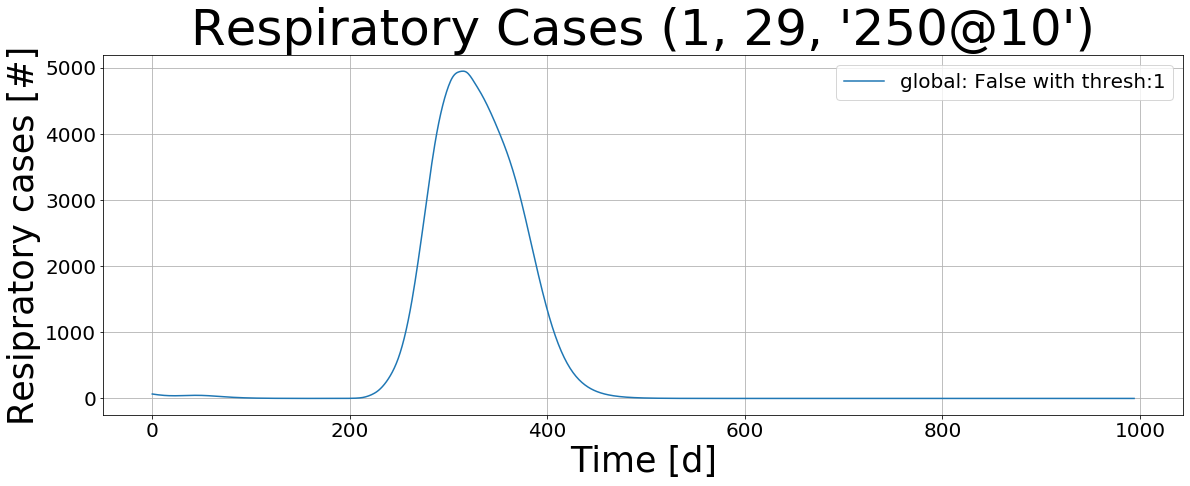

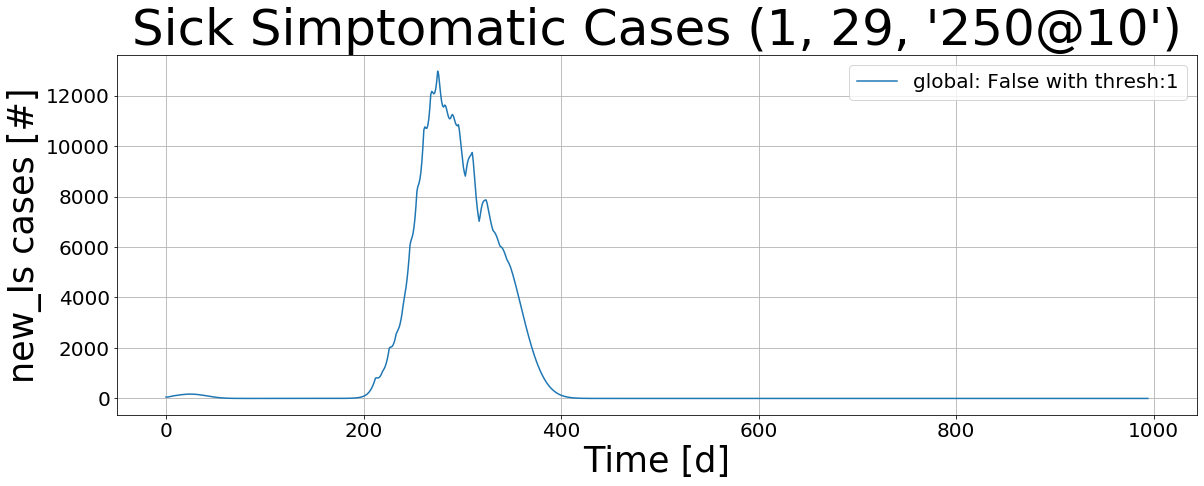

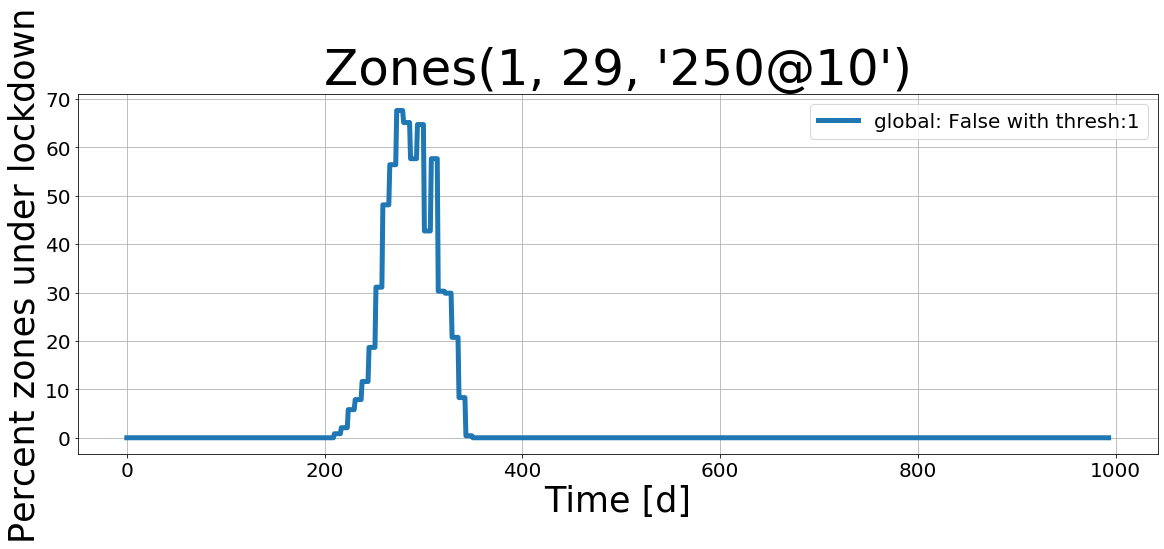

In [28]:
from PolicyOptimization import EvaluatePolicy as pol

scen='Scenario1'
phase = 29
thresh = 1
glob = False
stop = mdl.inter2name(ind, 10)
free = mdl.inter2name(ind, 100, no_risk=False)
howlong = 1000

policy_params = {
    'weight_matrix': np.zeros([4,9]),
    'deg_param': None,
    'policy_period': 7,
    'max_duration': 100,
    'stop_inter': stop,
    'free_inter': free,
    
    'global_thresh': glob,
    'global_lock': glob,
    
    'threshold': thresh,
}
# [Is, new_Is, H, Vent]
policy_params['weight_matrix'][1][:] = 1

start_inter = pd.Timestamp('2020-05-08')
beginning = pd.Timestamp('2020-02-20')

cal_parameters = pd.read_pickle('../Data/calibration/calibration_dict.pickle')

if phase == '-':
    seasonality = False
    phi=0
else:
    seasonality = True
    phi=phase

scen_idx = int(scen[-1])
model = mdl.Model_behave(
    ind=ind, 
    beta_j=cal_parameters[ind.cell_name][(scen_idx, phase)]['beta_j'],
    theta=cal_parameters[ind.cell_name][(scen_idx, phase)]['theta'],
    beta_behave=cal_parameters[ind.cell_name][(scen_idx, phase)]['beta_behave'],
    mu=cal_parameters[ind.cell_name][(scen_idx, phase)]['mu'],
    nu=cal_parameters[ind.cell_name][(scen_idx, phase)]['nu'],
    eta=cal_parameters[ind.cell_name][(scen_idx, phase)]['eta'],
    xi=cal_parameters[ind.cell_name][(scen_idx, phase)]['xi'],
    scen=mdl.num2scen(scen_idx),
    seasonality=seasonality,
    phi=phi,
)
    
res = model.predict(
    C=mdl.C_calibration,
    days_in_season=(start_inter-beginning).days,
    stay_home_idx=mdl.stay_home_idx,
    not_routine=mdl.not_routine,
)

res_mdl, pol_states = pol.run_global_policy(
    ind, 
    model, 
    policy_params, 
    howlong, 
    mdl.pop_israel,
    start=(start_inter-beginning).days,
)

# number of resperatory cases global.
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_position([0, 0.5, 1, 0.5])
ax.plot(
    ((res_mdl['Vents']).sum(axis=1))[(start_inter-beginning).days:]*mdl.pop_israel, 
    label=('global: '+ 
           str(glob) +
           ' with thresh:' + 
           str(thresh)))
ax.set_ylabel('Resipratory cases [#]', fontsize=35)
ax.set_title('Respiratory Cases ' + str((scen_idx, phase, stop)), fontsize=50)
ax.set_xlabel('Time [d]', fontsize=35)
# ax.axvline(x=(start_inter-beginning).days+7, c='k', linewidth=2, linestyle='--')
ax.legend(fontsize = 20)
ax.grid('on')
plt.setp(ax.get_xticklabels(), fontsize=20)    
plt.setp(ax.get_yticklabels(), fontsize=20) 
plt.show()

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_position([0, 0.5, 1, 0.5])
ax.plot(
    ((res_mdl['new_Is']).sum(axis=1))[(start_inter-beginning).days:]*mdl.pop_israel, 
    label=('global: '+ 
           str(glob) +
           ' with thresh:' + 
           str(thresh)))
ax.set_ylabel('new_Is cases [#]', fontsize=35)
ax.set_title('Sick Simptomatic Cases ' + str((scen_idx, phase, stop)), fontsize=50)
ax.set_xlabel('Time [d]', fontsize=35)

ax.legend(fontsize = 20)
ax.grid('on')
plt.setp(ax.get_xticklabels(), fontsize=20)    
plt.setp(ax.get_yticklabels(), fontsize=20) 
plt.show()

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_position([0, 0.5, 1, 0.5])
pol_pct = [100*sum(list(x.values()))/len(x) for x in pol_states]
ax.plot(pol_pct,linewidth=5, label=('global: '+ 
               str(glob) +
               ' with thresh:' + 
               str(thresh)))
ax.set_ylabel('Percent zones under lockdown', fontsize=35)
ax.set_xlabel('Time [d]', fontsize=35)
ax.set_title('Zones' + str((scen_idx, phase, stop)), fontsize=50)
ax.grid('on')
ax.legend(fontsize = 20)
plt.setp(ax.get_xticklabels(), fontsize=20)    
plt.setp(ax.get_yticklabels(), fontsize=20) 
plt.show()

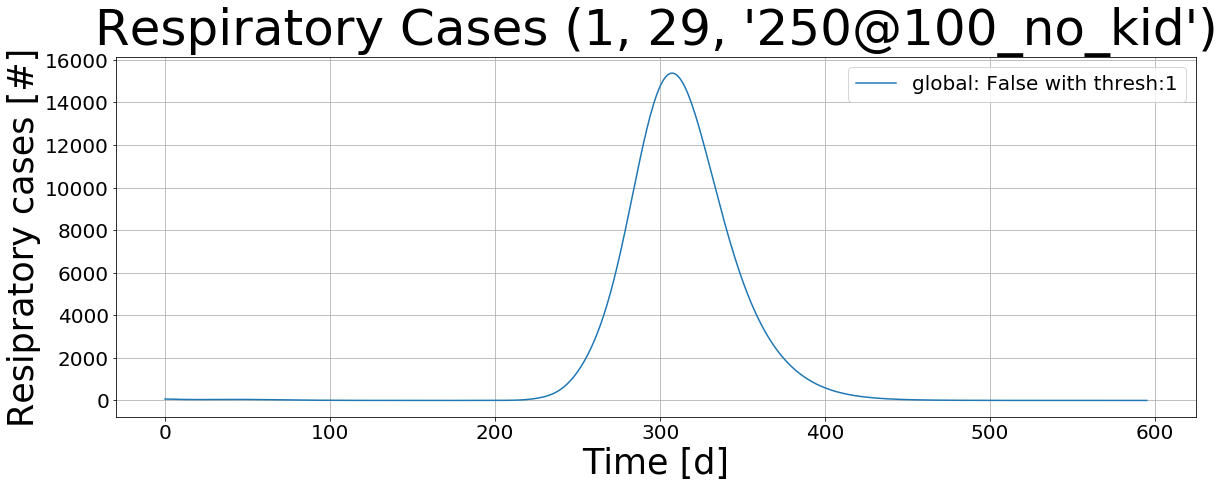

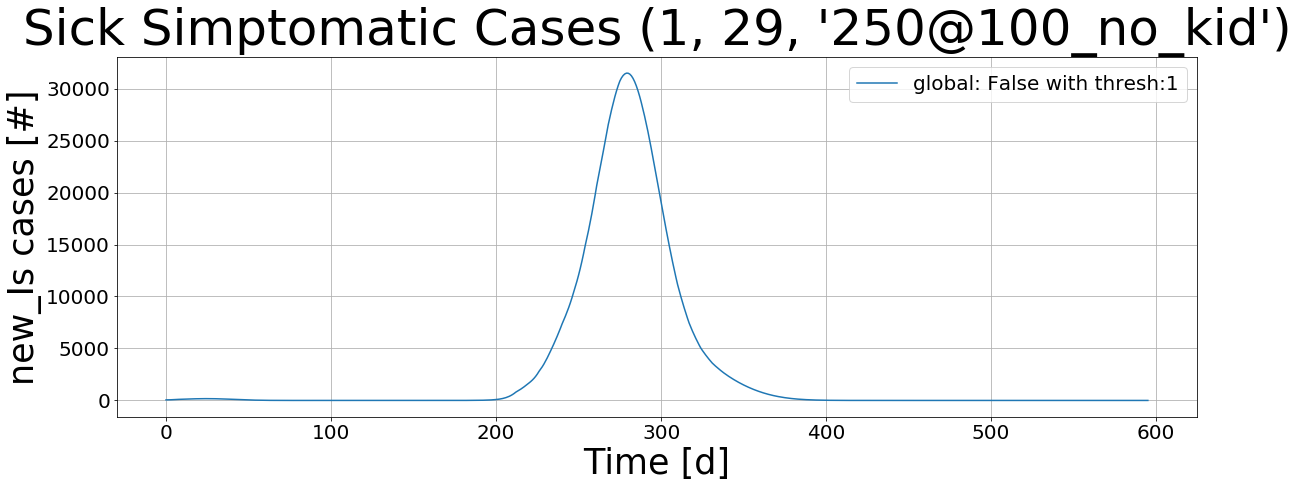

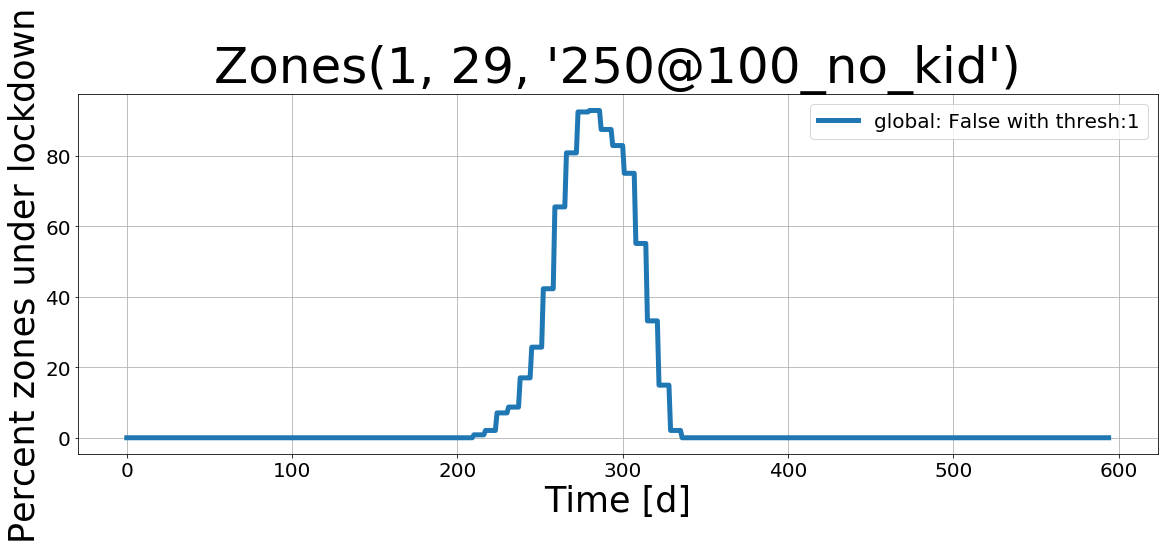

In [29]:
from PolicyOptimization import EvaluatePolicy as pol

scen='Scenario1'
phase = 29
thresh = 1
glob = False
stop = mdl.inter2name(ind, 100, no_kid=True)
free = mdl.inter2name(ind, 100, no_risk=False)
howlong = 600

policy_params = {
    'weight_matrix': np.zeros([4,9]),
    'deg_param': None,
    'policy_period': 7,
    'max_duration': 100,
    'stop_inter': stop,
    'free_inter': free,
    
    'global_thresh': glob,
    'global_lock': glob,
    
    'threshold': thresh,
}
# [Is, new_Is, H, Vent]
policy_params['weight_matrix'][1][:] = 1

start_inter = pd.Timestamp('2020-05-08')
beginning = pd.Timestamp('2020-02-20')

cal_parameters = pd.read_pickle('../Data/calibration/calibration_dict.pickle')

if phase == '-':
    seasonality = False
    phi=0
else:
    seasonality = True
    phi=phase

scen_idx = int(scen[-1])
model = mdl.Model_behave(
    ind=ind, 
    beta_j=cal_parameters[ind.cell_name][(scen_idx, phase)]['beta_j'],
    theta=cal_parameters[ind.cell_name][(scen_idx, phase)]['theta'],
    beta_behave=cal_parameters[ind.cell_name][(scen_idx, phase)]['beta_behave'],
    mu=cal_parameters[ind.cell_name][(scen_idx, phase)]['mu'],
    nu=cal_parameters[ind.cell_name][(scen_idx, phase)]['nu'],
    eta=cal_parameters[ind.cell_name][(scen_idx, phase)]['eta'],
    xi=cal_parameters[ind.cell_name][(scen_idx, phase)]['xi'],
    scen=mdl.num2scen(scen_idx),
    seasonality=seasonality,
    phi=phi,
)
    
res = model.predict(
    C=mdl.C_calibration,
    days_in_season=(start_inter-beginning).days,
    stay_home_idx=mdl.stay_home_idx,
    not_routine=mdl.not_routine,
)

res_mdl, pol_states = pol.run_global_policy(
    ind, 
    model, 
    policy_params, 
    howlong, 
    mdl.pop_israel,
    start=(start_inter-beginning).days,
)

# number of resperatory cases global.
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_position([0, 0.5, 1, 0.5])
ax.plot(
    ((res_mdl['Vents']).sum(axis=1))[(start_inter-beginning).days:]*mdl.pop_israel, 
    label=('global: '+ 
           str(glob) +
           ' with thresh:' + 
           str(thresh)))
ax.set_ylabel('Resipratory cases [#]', fontsize=35)
ax.set_title('Respiratory Cases ' + str((scen_idx, phase, stop)), fontsize=50)
ax.set_xlabel('Time [d]', fontsize=35)
# ax.axvline(x=(start_inter-beginning).days+7, c='k', linewidth=2, linestyle='--')
ax.legend(fontsize = 20)
ax.grid('on')
plt.setp(ax.get_xticklabels(), fontsize=20)    
plt.setp(ax.get_yticklabels(), fontsize=20) 
plt.show()

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_position([0, 0.5, 1, 0.5])
ax.plot(
    ((res_mdl['new_Is']).sum(axis=1))[(start_inter-beginning).days:]*mdl.pop_israel, 
    label=('global: '+ 
           str(glob) +
           ' with thresh:' + 
           str(thresh)))
ax.set_ylabel('new_Is cases [#]', fontsize=35)
ax.set_title('Sick Simptomatic Cases ' + str((scen_idx, phase, stop)), fontsize=50)
ax.set_xlabel('Time [d]', fontsize=35)

ax.legend(fontsize = 20)
ax.grid('on')
plt.setp(ax.get_xticklabels(), fontsize=20)    
plt.setp(ax.get_yticklabels(), fontsize=20) 
plt.show()

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_position([0, 0.5, 1, 0.5])
pol_pct = [100*sum(list(x.values()))/len(x) for x in pol_states]
ax.plot(pol_pct,linewidth=5, label=('global: '+ 
               str(glob) +
               ' with thresh:' + 
               str(thresh)))
ax.set_ylabel('Percent zones under lockdown', fontsize=35)
ax.set_xlabel('Time [d]', fontsize=35)
ax.set_title('Zones' + str((scen_idx, phase, stop)), fontsize=50)
ax.grid('on')
ax.legend(fontsize = 20)
plt.setp(ax.get_xticklabels(), fontsize=20)    
plt.setp(ax.get_yticklabels(), fontsize=20) 
plt.show()

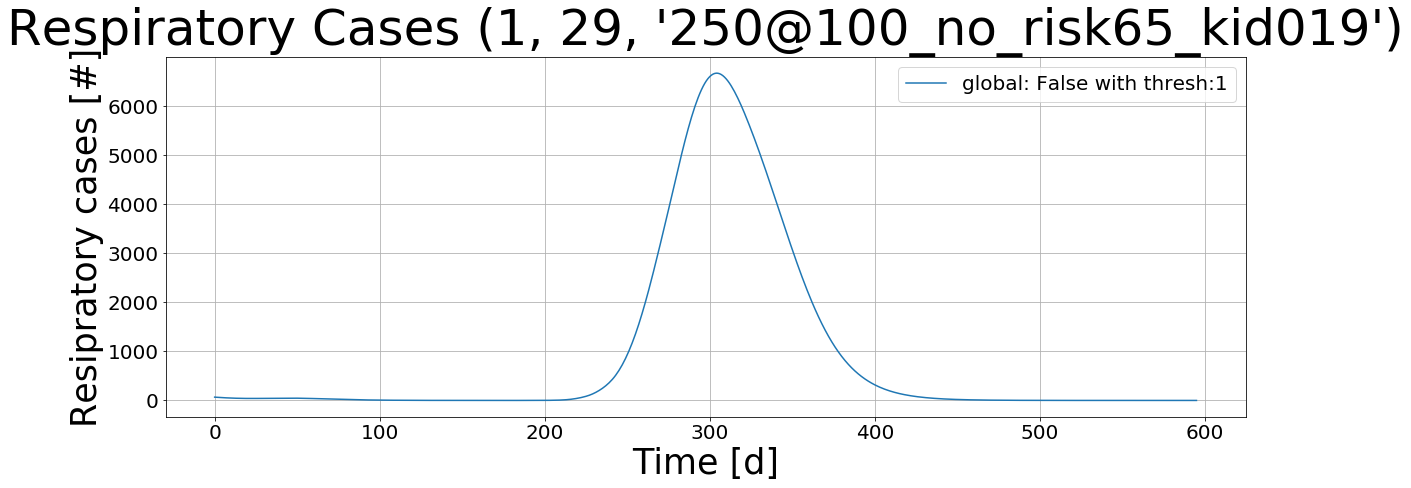

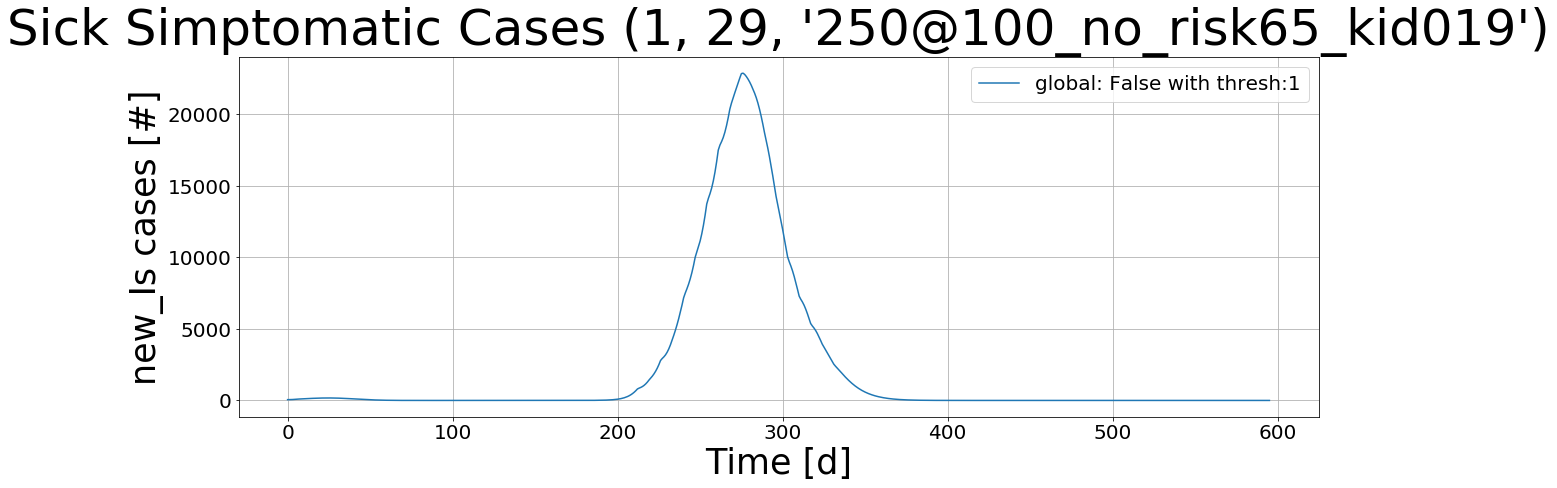

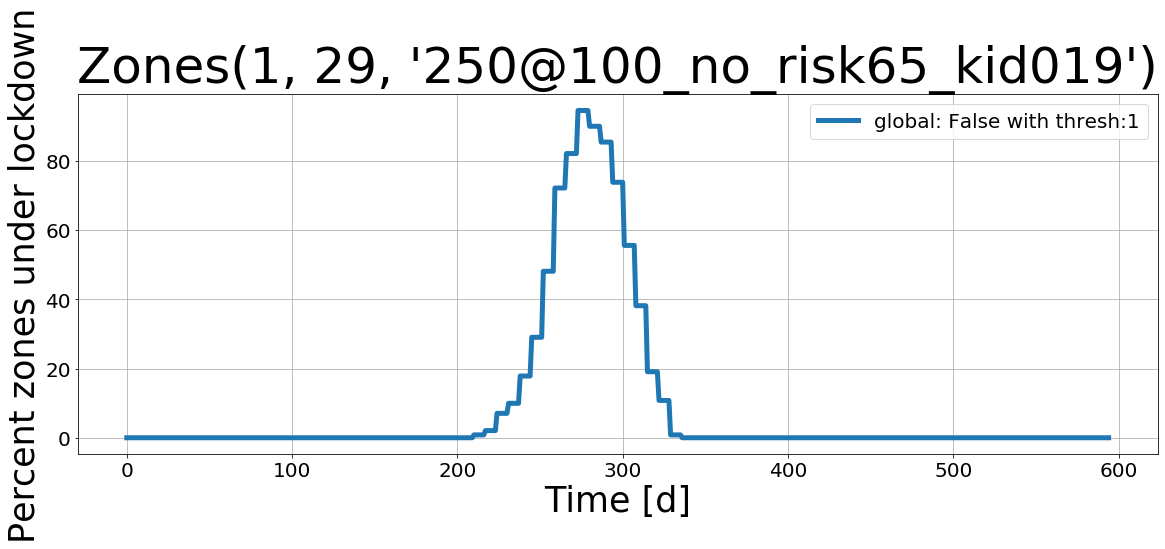

In [30]:
from PolicyOptimization import EvaluatePolicy as pol

scen='Scenario1'
phase = 29
thresh = 1
glob = False
stop = mdl.inter2name(ind, 100, no_risk=True)
free = mdl.inter2name(ind, 100, no_risk=False)
howlong = 600

policy_params = {
    'weight_matrix': np.zeros([4,9]),
    'deg_param': None,
    'policy_period': 7,
    'max_duration': 100,
    'stop_inter': stop,
    'free_inter': free,
    
    'global_thresh': glob,
    'global_lock': glob,
    
    'threshold': thresh,
}
# [Is, new_Is, H, Vent]
policy_params['weight_matrix'][1][:] = 1

start_inter = pd.Timestamp('2020-05-08')
beginning = pd.Timestamp('2020-02-20')

cal_parameters = pd.read_pickle('../Data/calibration/calibration_dict.pickle')

if phase == '-':
    seasonality = False
    phi=0
else:
    seasonality = True
    phi=phase

scen_idx = int(scen[-1])
model = mdl.Model_behave(
    ind=ind, 
    beta_j=cal_parameters[ind.cell_name][(scen_idx, phase)]['beta_j'],
    theta=cal_parameters[ind.cell_name][(scen_idx, phase)]['theta'],
    beta_behave=cal_parameters[ind.cell_name][(scen_idx, phase)]['beta_behave'],
    mu=cal_parameters[ind.cell_name][(scen_idx, phase)]['mu'],
    nu=cal_parameters[ind.cell_name][(scen_idx, phase)]['nu'],
    eta=cal_parameters[ind.cell_name][(scen_idx, phase)]['eta'],
    xi=cal_parameters[ind.cell_name][(scen_idx, phase)]['xi'],
    scen=mdl.num2scen(scen_idx),
    seasonality=seasonality,
    phi=phi,
)
    
res = model.predict(
    C=mdl.C_calibration,
    days_in_season=(start_inter-beginning).days,
    stay_home_idx=mdl.stay_home_idx,
    not_routine=mdl.not_routine,
)

res_mdl, pol_states = pol.run_global_policy(
    ind, 
    model, 
    policy_params, 
    howlong, 
    mdl.pop_israel,
    start=(start_inter-beginning).days,
)

# number of resperatory cases global.
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_position([0, 0.5, 1, 0.5])
ax.plot(
    ((res_mdl['Vents']).sum(axis=1))[(start_inter-beginning).days:]*mdl.pop_israel, 
    label=('global: '+ 
           str(glob) +
           ' with thresh:' + 
           str(thresh)))
ax.set_ylabel('Resipratory cases [#]', fontsize=35)
ax.set_title('Respiratory Cases ' + str((scen_idx, phase, stop)), fontsize=50)
ax.set_xlabel('Time [d]', fontsize=35)
# ax.axvline(x=(start_inter-beginning).days+7, c='k', linewidth=2, linestyle='--')
ax.legend(fontsize = 20)
ax.grid('on')
plt.setp(ax.get_xticklabels(), fontsize=20)    
plt.setp(ax.get_yticklabels(), fontsize=20) 
plt.show()

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_position([0, 0.5, 1, 0.5])
ax.plot(
    ((res_mdl['new_Is']).sum(axis=1))[(start_inter-beginning).days:]*mdl.pop_israel, 
    label=('global: '+ 
           str(glob) +
           ' with thresh:' + 
           str(thresh)))
ax.set_ylabel('new_Is cases [#]', fontsize=35)
ax.set_title('Sick Simptomatic Cases ' + str((scen_idx, phase, stop)), fontsize=50)
ax.set_xlabel('Time [d]', fontsize=35)

ax.legend(fontsize = 20)
ax.grid('on')
plt.setp(ax.get_xticklabels(), fontsize=20)    
plt.setp(ax.get_yticklabels(), fontsize=20) 
plt.show()

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_position([0, 0.5, 1, 0.5])
pol_pct = [100*sum(list(x.values()))/len(x) for x in pol_states]
ax.plot(pol_pct,linewidth=5, label=('global: '+ 
               str(glob) +
               ' with thresh:' + 
               str(thresh)))
ax.set_ylabel('Percent zones under lockdown', fontsize=35)
ax.set_xlabel('Time [d]', fontsize=35)
ax.set_title('Zones' + str((scen_idx, phase, stop)), fontsize=50)
ax.grid('on')
ax.legend(fontsize = 20)
plt.setp(ax.get_xticklabels(), fontsize=20)    
plt.setp(ax.get_yticklabels(), fontsize=20) 
plt.show()

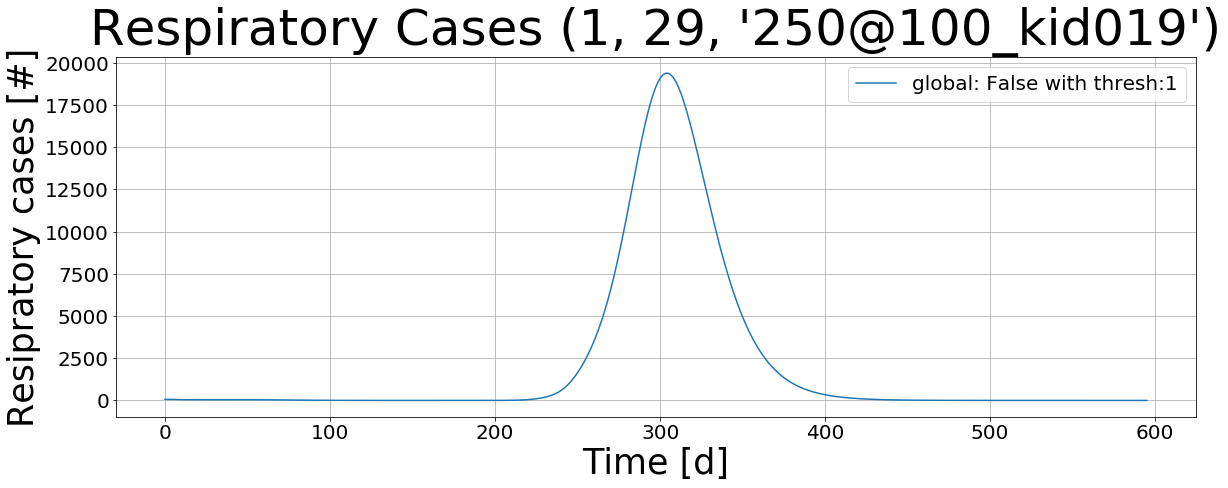

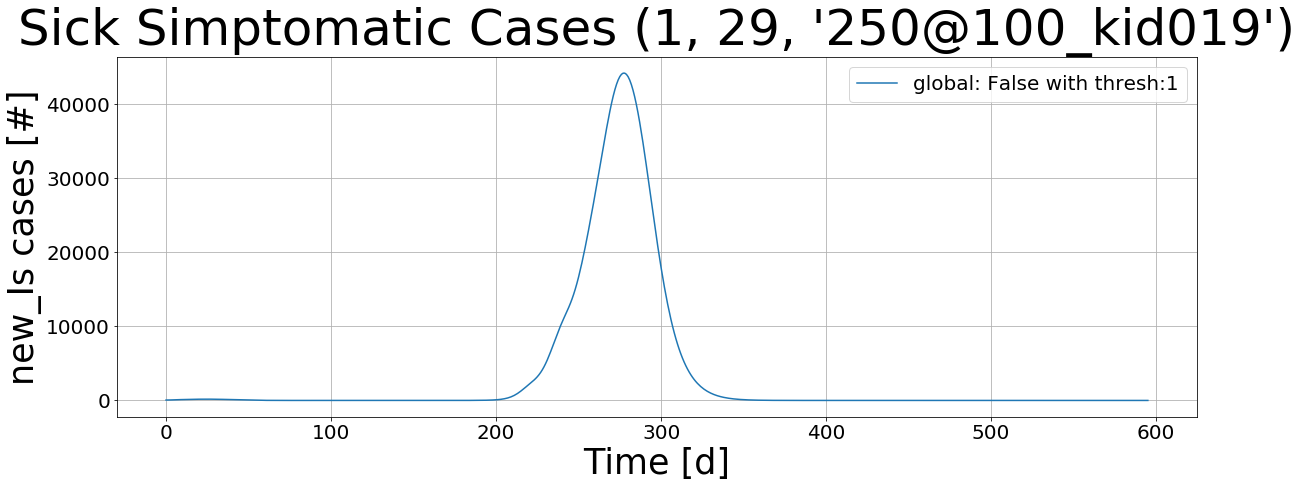

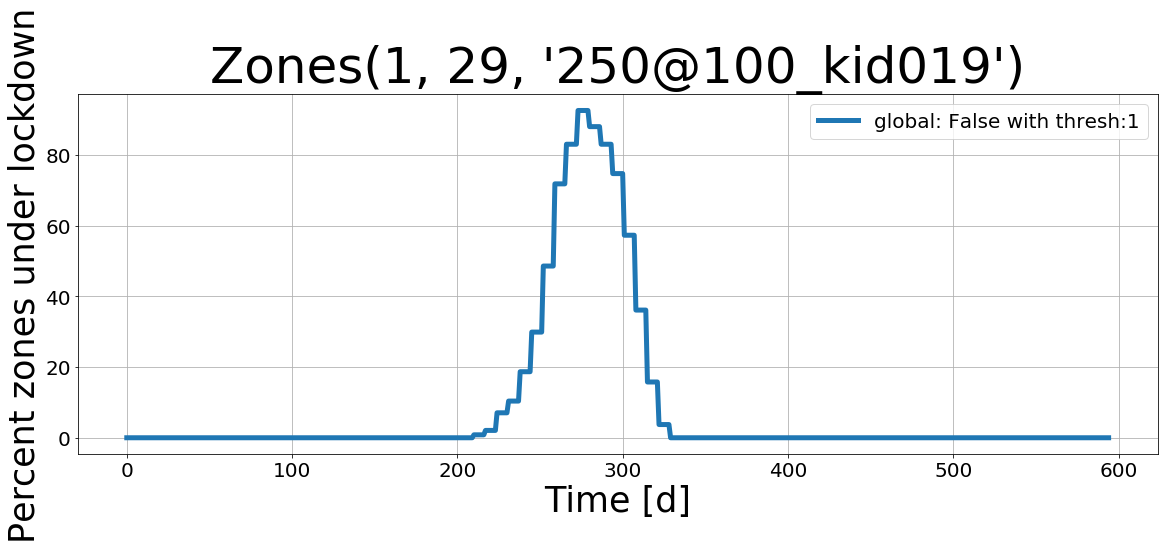

In [31]:
from PolicyOptimization import EvaluatePolicy as pol

scen='Scenario1'
phase = 29
thresh = 1
glob = False
stop = mdl.inter2name(ind, 100, no_risk=False)
free = mdl.inter2name(ind, 100, no_risk=False)
howlong = 600

policy_params = {
    'weight_matrix': np.zeros([4,9]),
    'deg_param': None,
    'policy_period': 7,
    'max_duration': 100,
    'stop_inter': stop,
    'free_inter': free,
    
    'global_thresh': glob,
    'global_lock': glob,
    
    'threshold': thresh,
}
# [Is, new_Is, H, Vent]
policy_params['weight_matrix'][1][:] = 1

start_inter = pd.Timestamp('2020-05-08')
beginning = pd.Timestamp('2020-02-20')

cal_parameters = pd.read_pickle('../Data/calibration/calibration_dict.pickle')

if phase == '-':
    seasonality = False
    phi=0
else:
    seasonality = True
    phi=phase

scen_idx = int(scen[-1])
model = mdl.Model_behave(
    ind=ind, 
    beta_j=cal_parameters[ind.cell_name][(scen_idx, phase)]['beta_j'],
    theta=cal_parameters[ind.cell_name][(scen_idx, phase)]['theta'],
    beta_behave=cal_parameters[ind.cell_name][(scen_idx, phase)]['beta_behave'],
    mu=cal_parameters[ind.cell_name][(scen_idx, phase)]['mu'],
    nu=cal_parameters[ind.cell_name][(scen_idx, phase)]['nu'],
    eta=cal_parameters[ind.cell_name][(scen_idx, phase)]['eta'],
    xi=cal_parameters[ind.cell_name][(scen_idx, phase)]['xi'],
    scen=mdl.num2scen(scen_idx),
    seasonality=seasonality,
    phi=phi,
)
    
res = model.predict(
    C=mdl.C_calibration,
    days_in_season=(start_inter-beginning).days,
    stay_home_idx=mdl.stay_home_idx,
    not_routine=mdl.not_routine,
)

res_mdl, pol_states = pol.run_global_policy(
    ind, 
    model, 
    policy_params, 
    howlong, 
    mdl.pop_israel,
    start=(start_inter-beginning).days,
)

# number of resperatory cases global.
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_position([0, 0.5, 1, 0.5])
ax.plot(
    ((res_mdl['Vents']).sum(axis=1))[(start_inter-beginning).days:]*mdl.pop_israel, 
    label=('global: '+ 
           str(glob) +
           ' with thresh:' + 
           str(thresh)))
ax.set_ylabel('Resipratory cases [#]', fontsize=35)
ax.set_title('Respiratory Cases ' + str((scen_idx, phase, stop)), fontsize=50)
ax.set_xlabel('Time [d]', fontsize=35)
# ax.axvline(x=(start_inter-beginning).days+7, c='k', linewidth=2, linestyle='--')
ax.legend(fontsize = 20)
ax.grid('on')
plt.setp(ax.get_xticklabels(), fontsize=20)    
plt.setp(ax.get_yticklabels(), fontsize=20) 
plt.show()

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_position([0, 0.5, 1, 0.5])
ax.plot(
    ((res_mdl['new_Is']).sum(axis=1))[(start_inter-beginning).days:]*mdl.pop_israel, 
    label=('global: '+ 
           str(glob) +
           ' with thresh:' + 
           str(thresh)))
ax.set_ylabel('new_Is cases [#]', fontsize=35)
ax.set_title('Sick Simptomatic Cases ' + str((scen_idx, phase, stop)), fontsize=50)
ax.set_xlabel('Time [d]', fontsize=35)

ax.legend(fontsize = 20)
ax.grid('on')
plt.setp(ax.get_xticklabels(), fontsize=20)    
plt.setp(ax.get_yticklabels(), fontsize=20) 
plt.show()

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_position([0, 0.5, 1, 0.5])
pol_pct = [100*sum(list(x.values()))/len(x) for x in pol_states]
ax.plot(pol_pct,linewidth=5, label=('global: '+ 
               str(glob) +
               ' with thresh:' + 
               str(thresh)))
ax.set_ylabel('Percent zones under lockdown', fontsize=35)
ax.set_xlabel('Time [d]', fontsize=35)
ax.set_title('Zones' + str((scen_idx, phase, stop)), fontsize=50)
ax.grid('on')
ax.legend(fontsize = 20)
plt.setp(ax.get_xticklabels(), fontsize=20)    
plt.setp(ax.get_yticklabels(), fontsize=20) 
plt.show()